# **Final Project**

For our final project we try to forecast stock price on a given day from a sequence from previous days data.

We will try several models, starting from a simple LSTM adapted from our Lab 2 work.  With some modifications:

* Removing the last linear layer activation function as we are going to do a forecast and not a classification.

* Reshaping the output dimensions so that we can predict as many features as we like.

* Changing the loss function into a MSE lost.


In [64]:
from google.colab import drive
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from torch.nn.modules import activation
import torch
from torch import nn
import torch.optim as optim

In [65]:
drive.mount('/content/drive')
myDrive = '/content/drive/Shareddrives/Deep_Learning_2024/Final/Data/Mixed_ETF/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
file_path = os.path.join(myDrive,'ETF_Data.csv')
data = pd.read_csv(file_path, sep=",", header=0)

Split Data

In [67]:
data.head()

,Date_vaw,Open_vaw,High_vaw,Low_vaw,Close_vaw,Volume_vaw,Open_vcr,High_vcr,Low_vcr,Close_vcr,...,Open_vht,High_vht,Low_vht,Close_vht,Volume_vht,Open_vnq,High_vnq,Low_vnq,Close_vnq,Volume_vnq
0,2005-02-25,54.737,55.614,54.737,55.594,20156,49.021,49.292,49.021,49.255,...,46.707,47.021,46.602,47.021,122102,39.719,40.308,39.719,40.272,39871
1,2005-02-28,55.728,55.728,54.855,55.194,47699,49.274,49.274,49.021,49.183,...,46.800,46.800,46.207,46.476,13375,40.301,40.401,39.749,40.156,72024
2,2005-03-01,55.418,55.640,55.041,55.130,17578,49.403,49.653,49.403,49.653,...,46.622,46.791,46.622,46.753,46598,40.079,40.577,40.079,40.577,45622
3,2005-03-02,54.649,55.263,54.649,55.085,11532,49.589,49.969,49.589,49.784,...,46.587,47.049,46.587,46.791,160287,40.308,40.499,40.207,40.308,20521
4,2005-03-03,55.409,55.409,54.855,55.122,28440,49.822,49.822,49.543,49.755,...,46.883,46.910,46.641,46.724,29446,40.308,40.569,40.224,40.522,12941


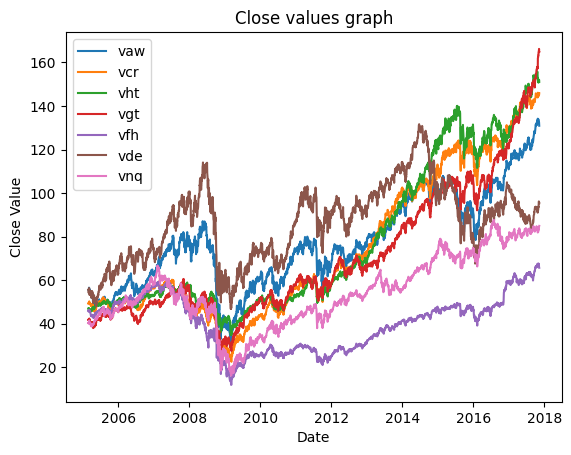

In [68]:
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vaw'], label='vaw')
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vcr'], label='vcr')
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vht'], label='vht')
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vgt'], label='vgt')
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vfh'], label='vfh')
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vde'], label='vde')
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vnq'], label='vnq')
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.title('Close values graph')
plt.legend()
plt.show()

In [69]:
data.rename(columns={'Date_vaw': 'Date'}, inplace=True)
data.index = data['Date']
data.pop('Date')
Train = data[:2560]
Test = data[2560:]
print(Train.shape)
print(Test.shape)
print(len(Test))

(2560, 35)
(641, 35)
641


In [70]:
import numpy as np

# Compute mean and std across samples and time steps for each feature
mean = np.mean(Train, axis=(0))
std = np.std(Train, axis=(0))
std[std == 0] = 1  # Prevent division by zero

# Normalize training data
Train_normalized = (Train - mean) / std

# Normalize test data
# Assuming you have test data: X_test, Y_test
Test_normalized = (Test - mean) / std

In [71]:
mode_list = ['multi', 'single']
ETF = ['vaw', 'vcr', 'vgt', 'vfh', 'vde', ' vht', 'vnq']

In [72]:
mode = 'single'
ETF_active = ETF[0];
fragment_size = 10;
step = 1

if (mode == mode_list[0]):
  Train_Fragmented = [Train_normalized.iloc[i:i + fragment_size] for i in range(0, len(Train_normalized) - fragment_size, step)]
  Train_Labels = [Train_normalized.iloc[i][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(fragment_size, len(Train_normalized), step)]

  Test_Fragmented = [Test_normalized .iloc[i:i + fragment_size] for i in range(0, len(Test_normalized ) - fragment_size, step)]
  Test_Labels = [Test_normalized .iloc[i][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(fragment_size, len(Test_normalized ), step)]
else:
  Train_Fragmented = [Train_normalized.iloc[i:i + fragment_size][['Open_'  + ETF_active,'High_' + ETF_active,'Low_'  + ETF_active,'Close_'  + ETF_active,'Volume_'  + ETF_active]] for i in range(0, len(Train_normalized) - fragment_size, step)]
  Train_Labels = [Train_normalized.iloc[i][['Close_'  + ETF_active]] for i in range(fragment_size, len(Train_normalized), step)]

  Test_Fragmented = [Test.iloc[i:i + fragment_size][['Open_'  + ETF_active,'High_' + ETF_active,'Low_'  + ETF_active,'Close_'  + ETF_active,'Volume_'  + ETF_active]] for i in range(0, len(Test_normalized ) - fragment_size, step)]
  Test_Labels = [Test.iloc[i][['Close_'  + ETF_active]] for i in range(fragment_size, len(Test_normalized ), step)]


In [73]:
# Print dimensions for verification
print(f'Number of Train Fragments: {len(Train_Fragmented)}')
print(f'Number of Train Labels: {len(Train_Labels)}')
print(f'Number of Test Fragments: {len(Test_Fragmented)}')
print(f'Number of Test Labels: {len(Test_Labels)}')


Number of Train Fragments: 2550
Number of Train Labels: 2550
Number of Test Fragments: 631
Number of Test Labels: 631


In [74]:
#Print start and end of training and test data for verification
print(f'\nTraining data\n')
print(Train_Fragmented[1]['Close_' + ETF_active])
print(Train_Labels[1])
print(Train_Fragmented[2]['Close_' + ETF_active])
print(Train_Labels[2])

print(Train_Fragmented[2548]['Close_' + ETF_active])
print(Train_Labels[2548])
print(Train_Fragmented[2549]['Close_' + ETF_active])
print(Train_Labels[2549])

print(f'\nTest data\n')
print(Test_Fragmented[0]['Close_' + ETF_active])
print(Test_Labels[0])
print(Test_Fragmented[1]['Close_' + ETF_active])
print(Test_Labels[1])

print(Test_Fragmented[629]['Close_' + ETF_active])
print(Test_Labels[629])
print(Test_Fragmented[630]['Close_' + ETF_active])
print(Test_Labels[630])


Training data

Date
2005-02-28   -0.906491
2005-03-01   -0.910282
2005-03-02   -0.912947
2005-03-03   -0.910756
2005-03-04   -0.823515
2005-03-07   -0.847857
2005-03-08   -0.862604
2005-03-09   -0.864085
2005-03-10   -0.911822
2005-03-11   -0.887539
Name: Close_vaw, dtype: float64
Close_vaw   -0.894942
Name: 2005-03-14, dtype: float64
Date
2005-03-01   -0.910282
2005-03-02   -0.912947
2005-03-03   -0.910756
2005-03-04   -0.823515
2005-03-07   -0.847857
2005-03-08   -0.862604
2005-03-09   -0.864085
2005-03-10   -0.911822
2005-03-11   -0.887539
2005-03-14   -0.894942
Name: Close_vaw, dtype: float64
Close_vaw   -0.903293
Name: 2005-03-15, dtype: float64
Date
2015-04-14    2.004853
2015-04-15    2.059934
2015-04-16    2.035651
2015-04-17    1.992415
2015-04-20    2.032097
2015-04-21    1.984716
2015-04-22    1.998930
2015-04-23    2.023805
2015-04-24    2.061710
2015-04-27    2.097246
Name: Close_vaw, dtype: float64
Close_vaw    2.11383
Name: 2015-04-28, dtype: float64
Date
2015-04-15    

Date
2015-05-07    105.89
2015-05-08    107.32
2015-05-11    106.94
2015-05-12    105.92
2015-05-13    105.96
2015-05-14    107.17
2015-05-15    107.39
2015-05-18    107.29
2015-05-19    106.73
2015-05-20    106.68
Name: Close_vaw, dtype: float64
Date
2015-05-08    107.32
2015-05-11    106.94
2015-05-12    105.92
2015-05-13    105.96
2015-05-14    107.17
2015-05-15    107.39
2015-05-18    107.29
2015-05-19    106.73
2015-05-20    106.68
2015-05-21    107.01
Name: Close_vaw, dtype: float64


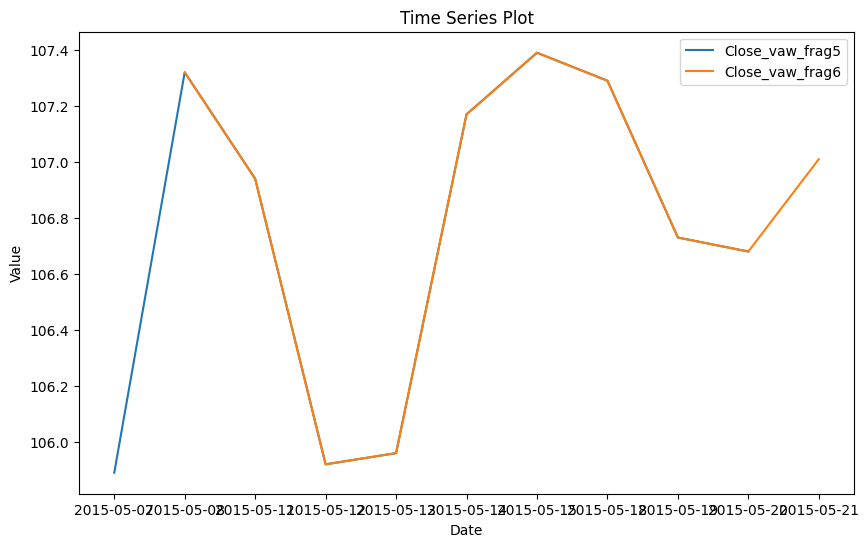

In [75]:
print(Test_Fragmented[5]['Close_' + ETF_active])
print(Test_Fragmented[6]['Close_' + ETF_active])
# Plot the time series data using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(Test_Fragmented[5].index, Test_Fragmented[5]['Close_' + ETF_active], label='Close_'  + ETF_active + '_frag5')
plt.plot(Test_Fragmented[6].index, Test_Fragmented[6]['Close_' + ETF_active], label='Close_'  + ETF_active + '_frag6')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Plot')
plt.legend()
plt.show()

In [76]:
# Define module encapsulating a Sequence Classifier using RNN or LSTMs and setting different architecture hyper-parameters
class Simple_LSTM(nn.Module):
  def __init__(self,
               input_size : int = 5,
               hidden_size : int = 64,
               output_size : int = 1,
               num_layers : int =  5,
               activation_function = nn.Softmax(dim = 1)):  #softmax activation function in order to get multiclass probability
    # Define RNN or LSTM architecture
    super().__init__()
    self.rnn =  nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                          num_layers=num_layers, batch_first = True)

    self.activation_function = activation_function

    self.last_linear = nn.Linear(hidden_size,output_size)

  def forward(self, X):
    _,last_states = self.rnn(X)
    # Get last hidden state for last layer. Ignore cell state in case of LSTMs
    last_hidden_state = last_states[0][-1, :, :]
    # Get sequence label probability using the last hidden state
    next_prediction = self.last_linear(last_hidden_state)
    return next_prediction


In [77]:
def train_simple_LSTM(X_train, Y_train, model, optimizer, loss_func, epochs=100):
    loss_its = []
    for iter in range(epochs):
      optimizer.zero_grad()
      output = model(X_train)
      loss = loss_func(output,Y_train)
      loss_its.append(loss.item())
      loss.backward()
      optimizer.step()
    print(f'Final loss: {loss.item()}')
    return np.asarray(loss_its)

In [78]:
tensor_list = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Train_Fragmented]
X_train = torch.stack(tensor_list)
label_tensor_list = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Train_Labels]
Y_train =  torch.stack(label_tensor_list)

tensor_list_test = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Test_Fragmented]
X_test = torch.stack(tensor_list_test)
label_tensor_list_test = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Test_Labels]
Y_test =  torch.stack(label_tensor_list_test)

In [79]:
X_train_pt = X_train.float().cuda()
Y_train_pt = Y_train.float().cuda()
X_test_pt = X_test.float().cuda()
Y_test_pt = Y_test.float().cuda()

print(X_train.shape)
print(Y_train.shape)

torch.Size([2550, 10, 5])
torch.Size([2550, 1])


In [80]:
'''if (mode == mode_list[0]):
  input_size = 35
  hidden_size = 256
  num_layers = 2
  output_size = 7
  num_epochs = 4000
else:
  input_size = 5
  hidden_size = 256
  num_layers = 2
  output_size = 1
  num_epochs = 4000

# Define model, loss function, and optimizer
model = Simple_LSTM(input_size=input_size, hidden_size=hidden_size, output_size = output_size, num_layers=num_layers).cuda()
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_history = train_simple_LSTM(X_train_pt, Y_train_pt, model, optimizer, loss_func, epochs=num_epochs)'''

'if (mode == mode_list[0]):\n  input_size = 35\n  hidden_size = 256\n  num_layers = 2\n  output_size = 7\n  num_epochs = 4000\nelse:\n  input_size = 5\n  hidden_size = 256\n  num_layers = 2\n  output_size = 1\n  num_epochs = 4000\n\n# Define model, loss function, and optimizer\nmodel = Simple_LSTM(input_size=input_size, hidden_size=hidden_size, output_size = output_size, num_layers=num_layers).cuda()\nloss_func = nn.MSELoss()\noptimizer = optim.Adam(model.parameters(), lr=0.001)\n\nloss_history = train_simple_LSTM(X_train_pt, Y_train_pt, model, optimizer, loss_func, epochs=num_epochs)'

In [81]:
if (mode == mode_list[0]):
  input_size = 35
  hidden_size = 256
  num_layers = 2
  output_size = 7
  num_epochs = 4000
else:
  input_size = 5
  hidden_size = 64
  num_layers = 2
  output_size = 1
  num_epochs = 4000

# Define model, loss function, and optimizer
model = Simple_LSTM(input_size=input_size, hidden_size=hidden_size, output_size = output_size, num_layers=num_layers).cuda()
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 4000
loss_its = []
for iter in range(num_epochs):
  optimizer.zero_grad()
  output = model(X_train_pt)
  loss = loss_func(output,Y_train_pt)
  loss_its.append(loss.item())
  loss.backward()
  optimizer.step()

  if( iter%100 == 0):
    print(f'Final loss: {loss.item()}')

#loss_history = train_simple_LSTM(X_train_pt, Y_train_pt, model, optimizer, loss_func, epochs=num_epochs)


Final loss: 0.9752925634384155
Final loss: 0.01166361290961504
Final loss: 0.010174439288675785
Final loss: 0.008789170533418655
Final loss: 0.00785944052040577
Final loss: 0.006967467255890369
Final loss: 0.0058397832326591015
Final loss: 0.004940943326801062
Final loss: 0.004409015644341707
Final loss: 0.004120346624404192
Final loss: 0.003948126453906298
Final loss: 0.005691492464393377
Final loss: 0.0037604630924761295
Final loss: 0.0037046477664262056
Final loss: 0.0037006549537181854
Final loss: 0.0036232618149369955
Final loss: 0.003585228929296136
Final loss: 0.00355002423748374
Final loss: 0.003545804414898157
Final loss: 0.0034986825194209814
Final loss: 0.0034703288692981005
Final loss: 0.003443096298724413
Final loss: 0.00343330972827971
Final loss: 0.0034080606419593096
Final loss: 0.003384664887562394
Final loss: 0.003409829456359148
Final loss: 0.0033534865360707045
Final loss: 0.003330826060846448
Final loss: 0.00342504377476871
Final loss: 0.0033017212990671396
Final l

# Histogram

In [82]:
Y_predicted = model(X_test_pt).cpu().detach().numpy()
if (mode == mode_list[0]):
  Y = Test_normalized[fragment_size:][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']]
else:
  Y = Test_normalized[fragment_size:][['Close_'  + ETF_active]]
Y = Y.to_numpy()
print(Y_predicted)

[[-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545606]
 [-0.97545

In [83]:
file_path = os.path.join(myDrive,'Y_predicted.csv')
pd.DataFrame(Y_predicted).to_csv(file_path, index=False)

Y_predicted shape: (631, 1)
Y shape after squeezing: (631,)


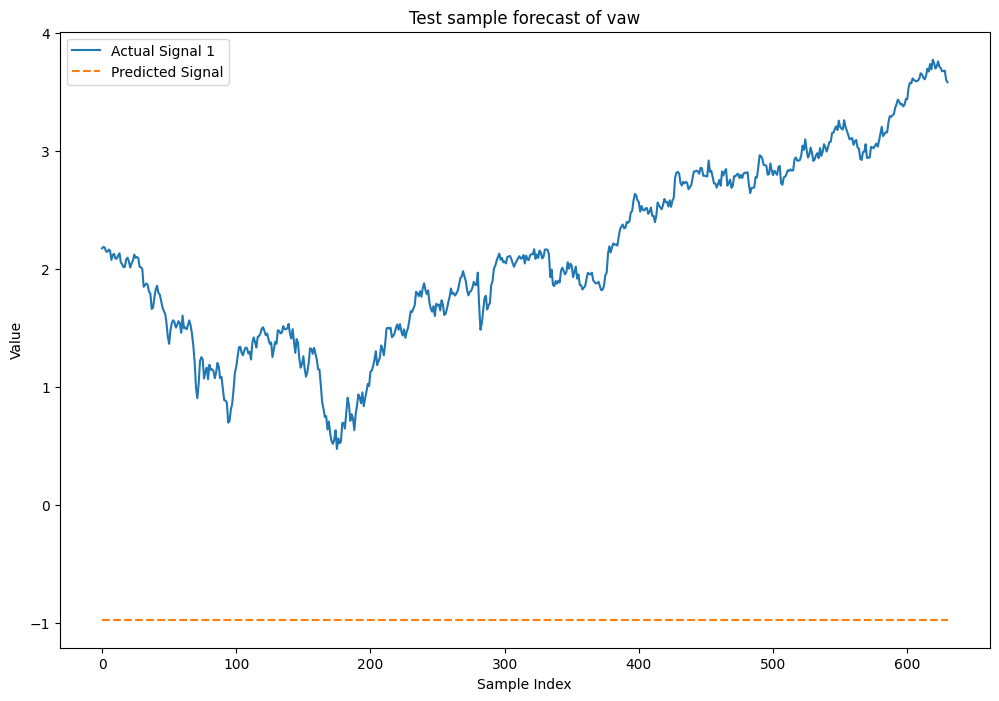

In [84]:
import matplotlib.pyplot as plt

# Example arrays for Y_predicted and Y
# Ensure these are defined as per your actual data
# Y_predicted = np.random.randn(640, 6)  # Example: If Y_predicted is a 2D array
# Y = np.random.randn(640, 6, 1)  # Example: If Y is a 3D array

# Ensure `Y` is 2D by squeezing the last dimension
Y_squeezed = Y.squeeze()

# Check the shapes (for debugging purposes)
print("Y_predicted shape:", Y_predicted.shape)
print("Y shape after squeezing:", Y_squeezed.shape)

# Plot the actual signals
plt.figure(figsize=(12, 8))
if Y_squeezed.ndim == 2:
  for i in range(Y_squeezed.shape[1]):
      plt.plot(Y_squeezed[:, i], label=f"Actual Signal {i+1}")
else:
  plt.plot(Y_squeezed[:], label=f"Actual Signal {1}")

# Ensure Y_predicted is compatible for plotting
if Y_predicted.shape[1] == 1:
    # If Y_predicted is 1D, we plot it directly
    plt.plot(Y_predicted, label="Predicted Signal", linestyle='--')
elif Y_predicted.ndim == 2 and Y_predicted.shape[1] == Y_squeezed.shape[1]:
    # If Y_predicted is 2D, plot each predicted signal
    for i in range(Y_predicted.shape[1]):
        plt.plot(Y_predicted[:, i], linestyle='--', label=f"Predicted Signal {i+1}")

plt.title('Test sample forecast of vaw')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()


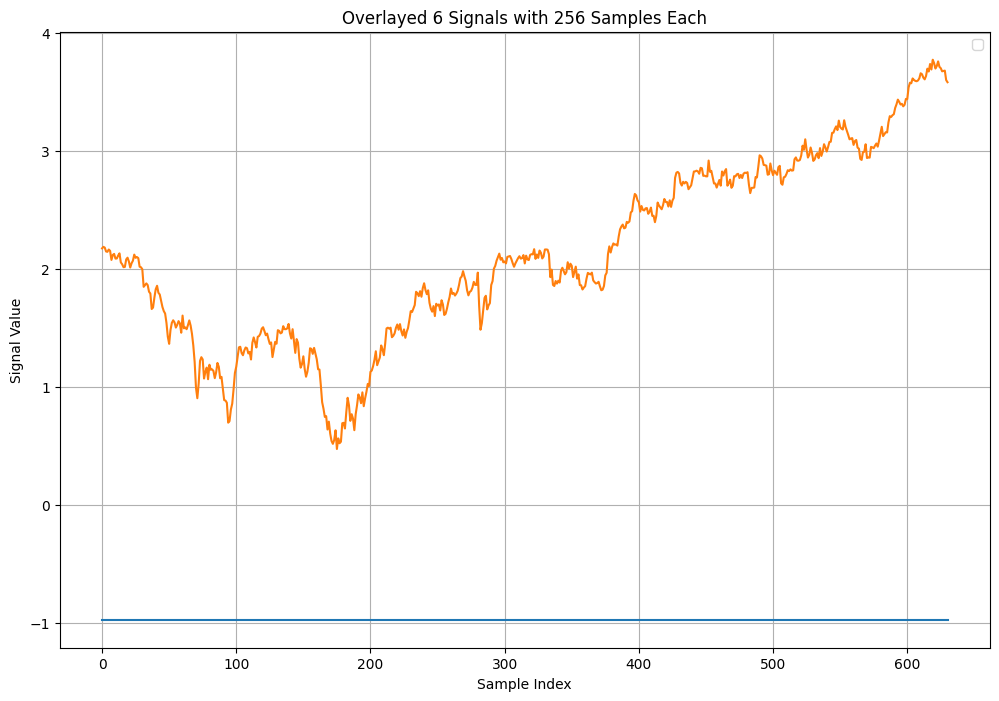

In [85]:
plt.figure(figsize=(12, 8))
plt.plot(Y_predicted)
plt.plot(Y)
plt.title('Overlayed 6 Signals with 256 Samples Each')
plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)
plt.show()